In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os, sys, re
import numpy as np
import random

from collections import defaultdict
from transformers import AutoTokenizer
from datasets import load_dataset
from grader import solution_eq_ans, extract_boxed_answer
from tqdm import tqdm

from rliable import plot_utils
plt.rcParams['text.usetex'] = False #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = r'\usepackage{sansmath} \sansmath' #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = ['Helveta Nue'] # Choose a nice font here
sns.set_style("whitegrid")

/home/myang4/miniconda3/envs/vllm3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/myang4/mrt-analysis/code/grader.py:106: SyntaxWarning: invalid escape sequence '\%'
  string = string.replace("\%", "")


In [2]:
output_dir = "/home/myang4/mrt-analysis/outputs/r1"

### Merge data

In [ ]:
data = {}
for start in range(0, 40, 10):
    with open(os.path.join(output_dir, f'pass_at_k_direct/pass_at_k_direct_{start}_{start+10}.pkl'), 'rb') as f:
        data |= pickle.load(f)

with open(os.path.join(output_dir, "pass_at_k_direct/pass_at_k_direct.pkl"), "wb") as f:
    pickle.dump(data, f)

INFO 04-20 18:05:06 __init__.py:183] Automatically detected platform cuda.


2025-04-20 18:05:06,368	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [ ]:
data = {}
for start in range(0, 40, 10):
    with open(os.path.join(output_dir, f'pass_at_k_given_prefix/pass_at_k_given_prefix_{start}_{start+10}.pkl'), 'rb') as f:
        data |= pickle.load(f)

with open(os.path.join(output_dir, "pass_at_k_given_prefix/pass_at_k_given_prefix.pkl"), "wb") as f:
    pickle.dump(data, f)

### Load data

In [3]:
math_dataset = load_dataset("hf-cmu-collab/omni_math_filtered", split="test")

In [4]:
with open(os.path.join(output_dir, "pass_at_k_direct/pass_at_k_direct.pkl"), "rb") as f:
    directs = pickle.load(f)

with open(os.path.join(output_dir, "pass_at_k_given_prefix/pass_at_k_given_prefix.pkl"), "rb") as f:
    rollouts = pickle.load(f)

INFO 04-20 18:28:18 __init__.py:183] Automatically detected platform cuda.


2025-04-20 18:28:18,444	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


### Check number of solutions that don't contain the answer

An concern is that the "stop think" phrase may lead to erratic behavior the model not producing an answer, so here's a simple check of the percentage of problems that don't contain a \\boxed{answer}.

In [5]:
tokenizer = AutoTokenizer.from_pretrained("/data/group_data/rl/myang4/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-32B/snapshots/711ad2ea6aa40cfca18895e8aca02ab92df1a746")

In [6]:
total = 0
exceeded = 0

prompts = []
examples = []
index = []
for n, k_completions in rollouts.items():
    for completions in k_completions:
        for prefix in completions:
            for r, rollout in enumerate(prefix.outputs):
                if extract_boxed_answer(prefix.prompt + rollout.text) is None:
                    prompts.append(prefix.prompt)
                    examples.append(rollout.text)
                    index.append(n)

                    exceeded += 1
                total += 1

print(exceeded / total)

0.06881009615384616


### Compute Maj@k

In [7]:
def compute_maj_at_k(answers_dict, k, correct_answer):
    answers = []
    for key, probs in answers_dict.items():
        for p in probs:
            answers.append((key, p))
    
    reward = 0
    for _ in range(100000):
        perm = random.sample(answers, k=k)

        counts = {}

        # ========================
        # MAJORITY LOGPROBS
        # ========================

        for key, probs in perm:
            if key not in counts:
                counts[key] = 2 ** probs
            else:
                counts[key] += 2 ** probs

        if correct_answer not in counts:
            correct_ans_probs = float('-inf')
        else:
            correct_ans_probs = counts[correct_answer]

        max_other_ans_probs = float('-inf')
        for ans, probs in counts.items():
            if ans != correct_answer and ans is not None:
                max_other_ans_probs = max(max_other_ans_probs, probs)

        if correct_ans_probs > max_other_ans_probs:
            reward += 1
        elif correct_ans_probs < max_other_ans_probs:
            reward += 0
        else:
            if correct_ans_probs == float('-inf') and max_other_ans_probs == float('-inf'):
                reward += 0
            else:
                reward += 0.5
    
    return reward / 100000

def calculate_likelihoods(output, L):
    logprob = 0
    length = 0
    
    for prob_dict, id in zip(output.logprobs[-L:], output.token_ids[-L:]):
        if prob_dict is None:
            continue
        logprob += prob_dict[id].logprob
        length += 1
        
    return logprob / length

def compute_pass_at_k(n, c, k):
    if n - c < k:
        return 1.0
    
    return 1.0 - np.prod(1.0 - k / np.arange(n - c + 1, n + 1))

In [8]:
problem_to_meta_step_to_pass_at_k_acc = defaultdict(list)
n_to_answer_dict = defaultdict(list)

for n, k_completions in tqdm(rollouts.items(), total=len(rollouts)):
    answer = str(math_dataset[n]['answer'])

    for c, completions in enumerate(k_completions):
        for prefix in completions:

            answers_dict = defaultdict(list)
            answers_dict[answer] = []

            total, correct = 0, 0
            
            for r, rollout in enumerate(prefix.outputs):

                correct += solution_eq_ans(prefix.prompt + rollout.text, str(answer))
                total += 1

                likelihood = calculate_likelihoods(rollout, 100000)
                
                if extract_boxed_answer(prefix.prompt + rollout.text) is None:
                    answers_dict[None].append(likelihood)
                    continue
                
                cur_keys = list(answers_dict.keys())
                found = False
                for key in cur_keys:
                    if key is None:
                        continue
                    if solution_eq_ans(prefix.prompt + rollout.text, key):
                        answers_dict[key].append(likelihood)
                        found = True
                        break

                if not found:
                    answers_dict[extract_boxed_answer(prefix.prompt + rollout.text)].append(likelihood)
                    assert solution_eq_ans(prefix.prompt + rollout.text, extract_boxed_answer(prefix.prompt + rollout.text))
        
            maj_at_k = [correct / total]
            for k in [2, 4, 8]:
                maj_at_k.append(compute_maj_at_k(answers_dict, k, answer))

            problem_to_meta_step_to_pass_at_k_acc[n * len(k_completions) + c].append(np.array(maj_at_k))

        problem_to_meta_step_to_pass_at_k_acc[n * len(k_completions) + c] = np.array(problem_to_meta_step_to_pass_at_k_acc[n * len(k_completions) + c])

with open(os.path.join(output_dir, "plot/maj@k.pkl"), "wb") as f:
    pickle.dump(problem_to_meta_step_to_pass_at_k_acc, f)

100%|██████████| 40/40 [13:49<00:00, 20.74s/it]


### Compute FLOPs

In [12]:
problem_to_meta_step_to_pass_at_k_flops = defaultdict(list)

for n, k_completions in tqdm(rollouts.items(), total=len(rollouts)):
    answer = math_dataset[n]['answer']

    for c, completions in enumerate(k_completions):
        for prefix in completions:
        
            base_flops = len(tokenizer.encode(prefix.prompt))
            flops = 0
            for r, rollout in enumerate(prefix.outputs):
                flops += len(tokenizer.encode(rollout.text))

            pass_at_k = []
            for i, k in enumerate([1, 2, 4, 8]):
                pass_at_k.append(base_flops + flops / 8 * k)
        
            problem_to_meta_step_to_pass_at_k_flops[n * len(k_completions) + c].append(np.array(pass_at_k))
        
        problem_to_meta_step_to_pass_at_k_flops[n * len(k_completions) + c] = np.array(problem_to_meta_step_to_pass_at_k_flops[n * len(k_completions) + c])

with open(os.path.join(output_dir, "plot/flops.pkl"), "wb") as f:
    pickle.dump(problem_to_meta_step_to_pass_at_k_flops, f)

100%|██████████| 40/40 [00:23<00:00,  1.68it/s]


### Compute direct

In [13]:
tokenizer = AutoTokenizer.from_pretrained("/data/group_data/rl/myang4/models--Qwen--Qwen2.5-32B-Instruct/snapshots/5ede1c97bbab6ce5cda5812749b4c0bdf79b18dd")

In [17]:
n_to_acc_pass_k = {}
for n in tqdm(directs):
    answer = math_dataset[n]['answer']
    
    total, correct = 0, 0
    for output in directs[n].outputs:
        correct += solution_eq_ans(output.text, str(answer))
        total += 1

    pass_k = []
    for k in [1, 2, 4, 8, 16, 32]:
        pass_k.append(compute_pass_at_k(total, correct, k))

    n_to_acc_pass_k[n] = np.array(pass_k)

with open(os.path.join(output_dir, "plot/direct_pass@k.pkl"), "wb") as f:
    pickle.dump(n_to_acc_pass_k, f)

n_to_flops_pass_k = {}
for n in tqdm(directs):

    flops = 0
    for output in directs[n].outputs:
        flops += len(output.token_ids)

    pass_k = []
    for k in [1, 2, 4, 8, 16, 32]:
        pass_k.append(flops / 32 * k)
    
    n_to_flops_pass_k[n] = np.array(pass_k)

with open(os.path.join(output_dir, "plot/direct_flops.pkl"), "wb") as f:
    pickle.dump(n_to_flops_pass_k, f)

100%|██████████| 40/40 [00:00<00:00, 64010.74it/s]


## Graphs

In [18]:
with open(os.path.join(output_dir, "plot/maj@k.pkl"), "rb") as f:
    maj_at_k = pickle.load(f)

with open(os.path.join(output_dir, "plot/flops.pkl"), "rb") as f:
    flops = pickle.load(f)

with open(os.path.join(output_dir, "plot/direct_pass@k.pkl"), "rb") as f:
    direct_pass_at_k = pickle.load(f)

with open(os.path.join(output_dir, "plot/direct_flops.pkl"), "rb") as f:
    direct_flops = pickle.load(f)

In [19]:
L_to_n = defaultdict(list)
for n in range(40):
    for t in range(4):
        L_to_n[len(maj_at_k[4*n+t])].append(4*n+t)

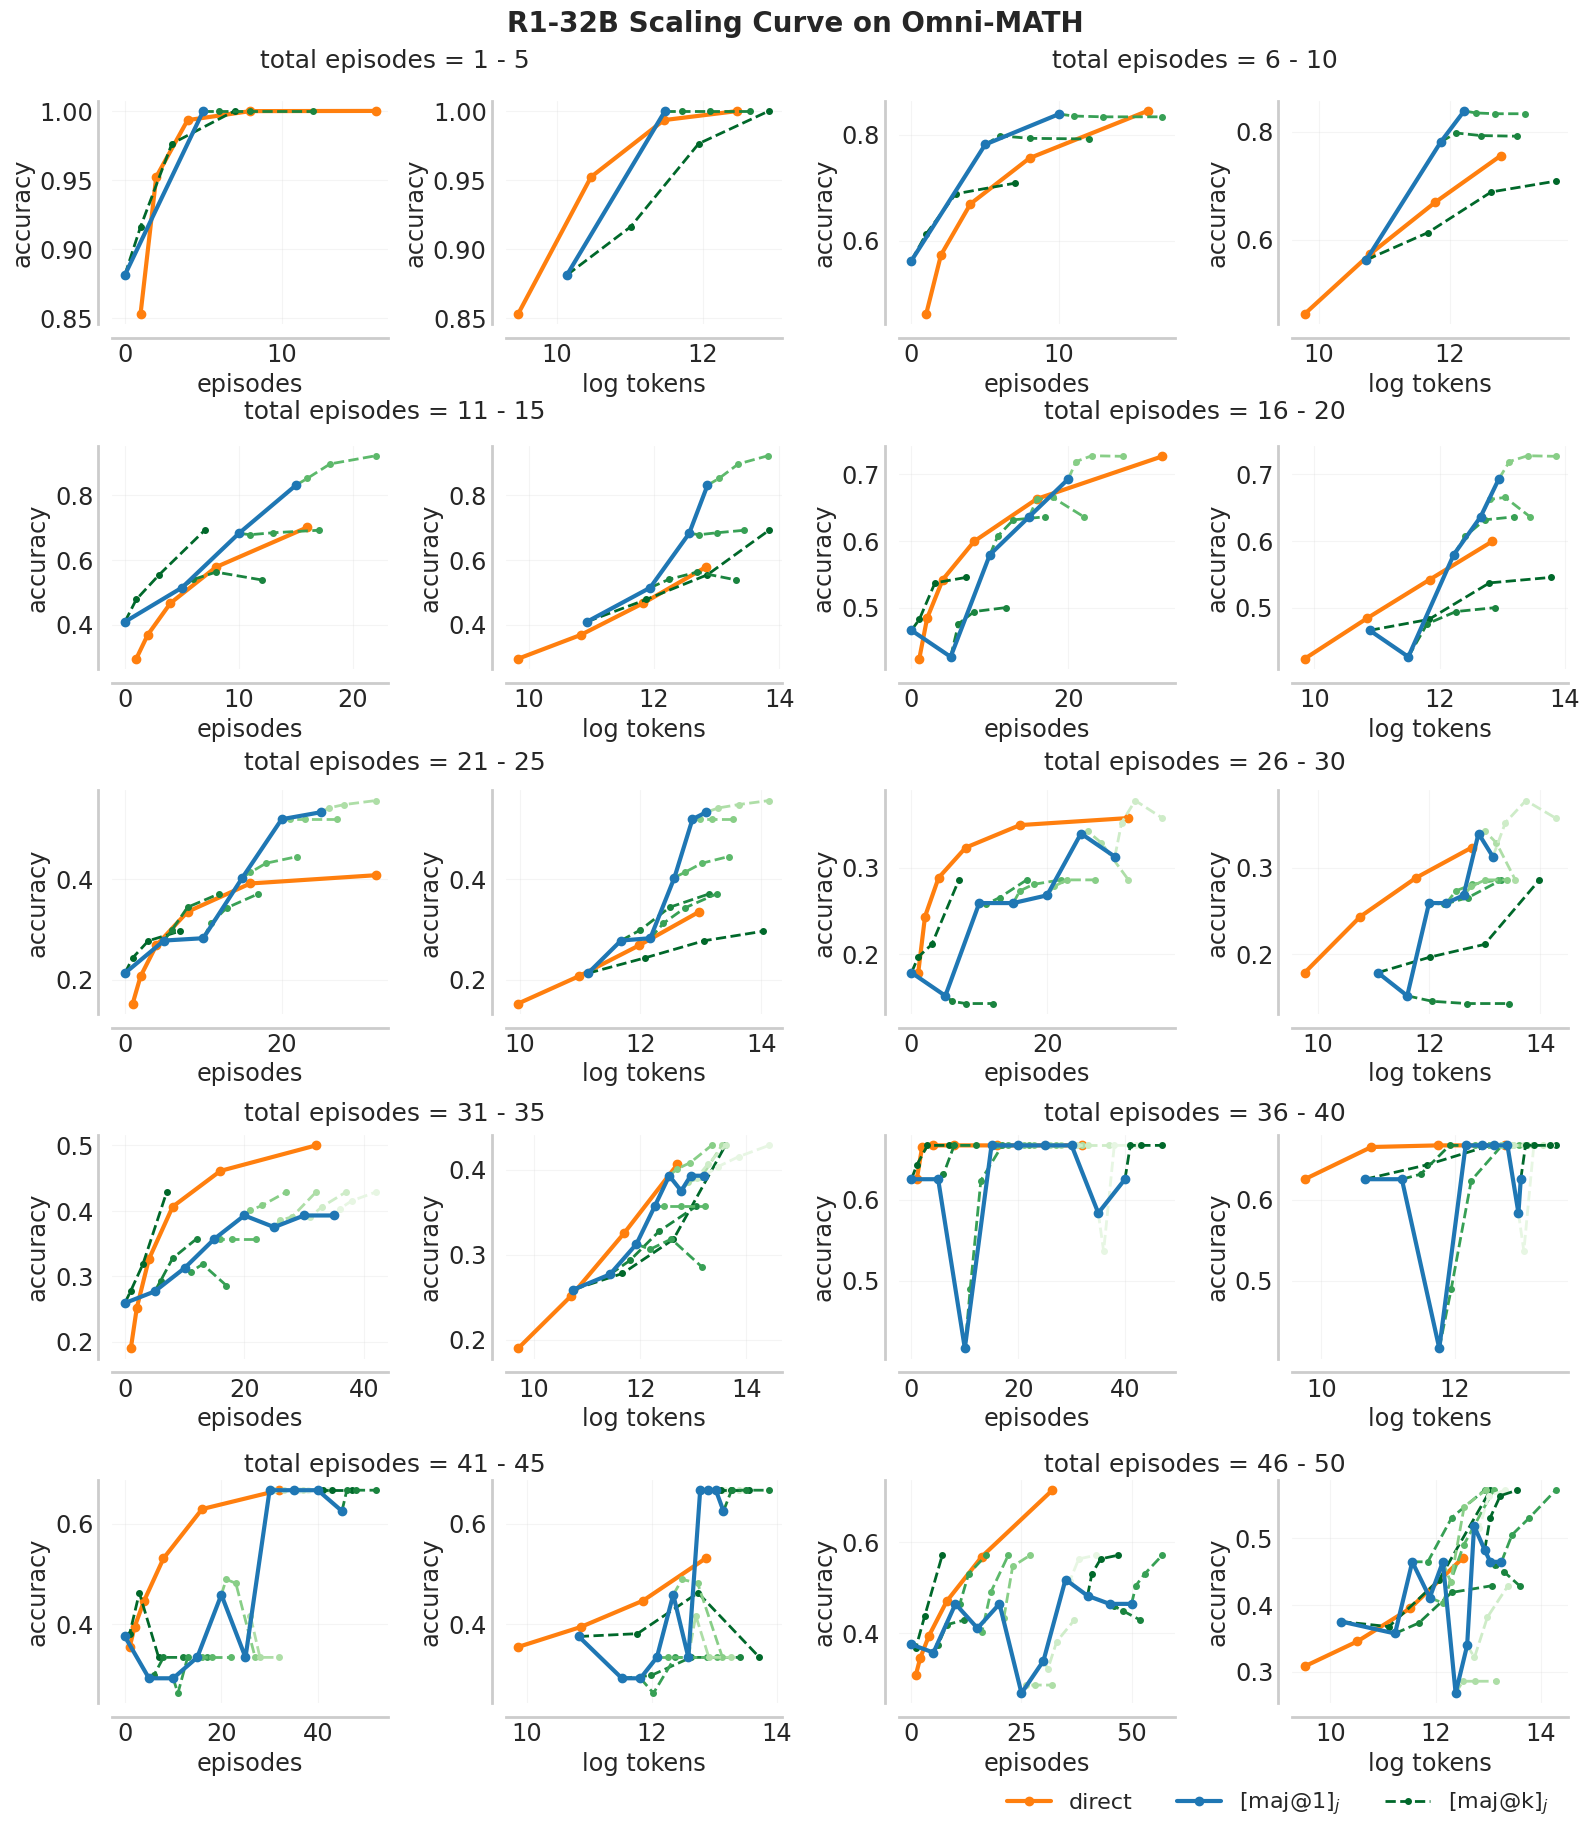

In [20]:
sns.set_palette("Greens_r", 8)

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(16, 13))
axes = axes.flatten()

subtitle_x_coords = [0.25, 0.75]
subtitle_y_coords = [1.34, 1.07, 0.8, 0.53, 0.26]

# L = total number of meta-steps
for plot, L in enumerate(range(2, 12)):
    if L not in L_to_n:
        continue

    for x_flops in [False, True]:

        # ====================
        # direct
        # ====================
        if x_flops:
            y = np.empty((0, 4))
            x = np.empty((0, 4))

            for index in L_to_n[L]:
                y = np.vstack((y, direct_pass_at_k[index // 4][:4]))
                x = np.vstack((x, direct_flops[index // 4][:4]))

            y = y.mean(axis=0)
            x = x.mean(axis=0)

            axes[2 * plot + x_flops].plot(np.log2(x), y, label="direct", marker='o', color='#ff7f0e', markersize=6, linewidth=3)

        else:
            if L < 5:
                y = np.empty((0, 5))
                x = np.empty((0, 5))

                for index in L_to_n[L]:
                    y = np.vstack((y, direct_pass_at_k[index // 4][:5]))
                    x = np.vstack((x, direct_flops[index // 4][:5]))

                y = y.mean(axis=0)
                x = x.mean(axis=0)

                axes[2 * plot + x_flops].plot(np.array([1, 2, 4, 8, 16]), y, label="direct", marker='o', color='#ff7f0e', markersize=6, linewidth=3)
            else:
                y = np.empty((0, 6))
                x = np.empty((0, 6))

                for index in L_to_n[L]:
                    y = np.vstack((y, direct_pass_at_k[index // 4]))
                    x = np.vstack((x, direct_flops[index // 4]))

                y = y.mean(axis=0)
                x = x.mean(axis=0)

                axes[2 * plot + x_flops].plot(np.array([1, 2, 4, 8, 16, 32]), y, label="direct", marker='o', color='#ff7f0e', markersize=6, linewidth=3)


        # ====================
        # maj@k branches
        # ====================
        for l in range(L):
            y = np.empty((0, 4))
            x = np.empty((0, 4))

            for index in L_to_n[L]:
                y = np.vstack((y, maj_at_k[index][l]))
                x = np.vstack((x, flops[index][l]))

            x = x.mean(axis=0)
            y = y.mean(axis=0)

            if x_flops:
                axes[2 * plot + x_flops].plot(np.log2(x), y, linestyle='--', marker='o', markersize=4, linewidth=2)
            else:
                axes[2 * plot + x_flops].plot(np.array([5 * l + 2 ** i - 1 for i in range(4)]), y, linestyle='--', marker='o', markersize=4, linewidth=2)




        # ====================
        # main maj@1 graph
        # ====================
        y = np.empty((0, L))
        x = np.empty((0, L))

        for index in L_to_n[L]:
            y = np.vstack((y, maj_at_k[index][:, 0]))
            x = np.vstack((x, flops[index][:, 0]))

        y = y.mean(axis=0)
        x = x.mean(axis=0)

        if x_flops:
            axes[2 * plot + x_flops].plot(np.log2(x), y, label="$[\\text{maj@1}]_j$", marker='o', color='#1f77b4', markersize=6, linewidth=3)
        else:
            axes[2 * plot + x_flops].plot(np.array([5 * l for l in range(L)]), y, label="$[\\text{maj@1}]_j$", marker='o', color='#1f77b4', markersize=6, linewidth=3)


        plot_utils._annotate_and_decorate_axis(axes[2 * plot + x_flops],
                                               xlabel='log tokens' if x_flops else 'episodes',
                                               ylabel='accuracy',
                                               labelsize='xx-large',
                                               ticklabelsize='xx-large',
                                               grid_alpha=0.2,
                                               legend=False)
    plt.figtext(subtitle_x_coords[plot % 2], subtitle_y_coords[plot // 2], f"total episodes = {(L - 2) * 5 + 1} - {(L - 1) * 5}", ha="center", va="top", fontsize=18)

fig.suptitle('R1-32B Scaling Curve on Omni-MATH', fontsize=20, fontweight='bold', y=1.37)

# add to legend
axes[-1].plot([], [], label=f"$[\\text{{maj@k}}]_{{j}}$", linestyle='--', marker='o', markersize=4, linewidth=2, color=sns.color_palette("Greens_r", 8)[0])

fig.tight_layout()
plt.subplots_adjust(top=1.3)
axes[-1].legend(prop={'size': 16}, frameon=False, bbox_to_anchor=(1, -0.3), ncol=3)
plt.show()